# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, hamming_loss

from gensim.models import Word2Vec, KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Dropout, Flatten, SimpleRNN, LSTM, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/datasets/train_cleaned.csv')

In [4]:
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,num_labels,merged,num_words_original,processed,num_words_processed
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,1,Reconstructing Subject-Specific Effect Maps ...,269,reconstruct subject specific effect map predic...,180
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,1,Rotation Invariance Neural Network Rotation ...,80,rotation invariance neural network rotation in...,49
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,1,Spherical polyharmonics and Poisson kernels fo...,107,spherical polyharmonic poisson kernel polyharm...,62
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,1,A finite element approximation for the stochas...,119,finite element approximation stochastic maxwel...,72
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,2,Comparative study of Discrete Wavelet Transfor...,145,comparative study discrete wavelet transforms ...,95


In [5]:
labels = ['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']
X = train['merged']
y = train[labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Simple Neural Network

First, I explore a simple neural network with embedding layer of dimension 300. 

## Preprocessing

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [7]:
X_train_tk = tokenizer.texts_to_sequences(X_train)
X_test_tk = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index

In [8]:
print(X_train_tk[4])

[4349, 156, 2, 2763, 5, 1, 785, 2367, 634, 2619, 300, 6350, 222, 7, 338, 1, 1985, 785, 2367, 634, 2619, 300, 6350, 224, 2154, 7176, 1116, 49, 7, 146, 3, 655, 2, 567, 212, 231, 970, 2, 2722, 2722, 696, 696, 4, 2722, 696, 2763, 5, 447, 6, 8859, 962, 7, 31, 10, 54, 21, 4818, 2722, 294, 71, 2142, 3, 696, 294, 71, 5, 3, 36, 2815, 188, 14, 8573, 1332, 1253, 1, 1549, 477, 227, 7, 42, 31, 10, 1, 107, 5, 113, 825, 1150, 5085, 1720, 1, 6351, 32398, 23, 7, 42, 1081, 1, 1315, 2, 1, 2815, 212, 5, 1753, 7, 5838, 10, 1, 859, 1449, 1986, 187, 6, 1, 13473, 2, 1, 23]


In [9]:
print(X_train[4])

Comparative study of Discrete Wavelet Transforms and Wavelet Tensor Train decomposition to feature extraction of FTIR data of medicinal plants   Fourier-transform infra-red (FTIR) spectra of samples from 7 plant species
were used to explore the influence of preprocessing and feature extraction on
efficiency of machine learning algorithms. Wavelet Tensor Train (WTT) and
Discrete Wavelet Transforms (DWT) were compared as feature extraction
techniques for FTIR data of medicinal plants. Various combinations of signal
processing steps showed different behavior when applied to classification and
clustering tasks. Best results for WTT and DWT found through grid search were
similar, significantly improving quality of clustering as well as
classification accuracy for tuned logistic regression in comparison to original
spectra. Unlike DWT, WTT has only one parameter to be tuned (rank), making it a
more versatile and easier to use as a data processing tool in various signal
processing application

In [10]:
# find maximum number of words in merged text
train_len = [len(text) for text in X_train_tk]
test_len = [len(text) for text in X_test_tk]
max_len = max(max(train_len), max(test_len))
print('Maximum length of text = {}'.format(max_len))

Maximum length of text = 467


In [11]:
# pad to same max length of both train and test
X_train_tk = pad_sequences(X_train_tk, maxlen = max_len)
X_test_tk = pad_sequences(X_test_tk, maxlen = max_len)
X_train_tk.shape, X_test_tk.shape

((16777, 467), (4195, 467))

In [12]:
y_test.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
20257,1,0,0,0,0,0
482,0,0,1,1,0,0
4189,1,0,1,0,0,0
9838,0,1,0,1,0,0
16591,1,0,0,0,0,0


## Model

In [ ]:
# 1 for reserved 0 index
vocab_size = len(tokenizer.word_counts) + 1

In [ ]:
embed_dim = 300 
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                   output_dim=embed_dim,
                   input_length=max_len,
                    trainable=True))
model.add(Flatten())
model.add(Dropout(0.2))  
model.add(Dense(64, activation='relu'))  
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='sigmoid'))  
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 467, 300)          15513900  
_________________________________________________________________
flatten (Flatten)            (None, 140100)            0         
_________________________________________________________________
dropout (Dropout)            (None, 140100)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                8966464   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          restore_best_weights=True,
                          mode='min'
                           )

In [ ]:
history = model.fit(X_train_tk, y_train,
                    epochs=100,  
                    verbose=True,
                    validation_data=(X_test_tk, y_test),
                    batch_size=128,
                    callbacks=early_stop
                    )  

Epoch 1/100
132/132 [==============================] - 25s 183ms/step - loss: 0.5524 - accuracy: 0.3563 - val_loss: 0.2466 - val_accuracy: 0.7631
Epoch 2/100
132/132 [==============================] - 23s 174ms/step - loss: 0.2621 - accuracy: 0.7227 - val_loss: 0.2120 - val_accuracy: 0.7399
Epoch 3/100
132/132 [==============================] - 24s 181ms/step - loss: 0.1679 - accuracy: 0.7920 - val_loss: 0.2096 - val_accuracy: 0.7552
Epoch 4/100
132/132 [==============================] - 24s 184ms/step - loss: 0.1081 - accuracy: 0.8293 - val_loss: 0.2330 - val_accuracy: 0.7621
Epoch 5/100
132/132 [==============================] - 25s 186ms/step - loss: 0.0747 - accuracy: 0.8460 - val_loss: 0.2542 - val_accuracy: 0.7416
Epoch 6/100
132/132 [==============================] - 24s 185ms/step - loss: 0.0606 - accuracy: 0.8645 - val_loss: 0.2737 - val_accuracy: 0.7547
Epoch 7/100
132/132 [==============================] - 24s 185ms/step - loss: 0.0505 - accuracy: 0.8566 - val_loss: 0.3019 -

In [ ]:
filepath='/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/models/simple NN'
model.save(filepath)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/models/simple NN/assets


In [ ]:
# load saved model to skip training
filepath='/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/models/simple NN'
model = load_model(filepath)

In [ ]:
loss, accuracy = model.evaluate(X_train_tk, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_tk, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))

525/525 [==============================] - 9s 17ms/step - loss: 0.0756 - accuracy: 0.8345
Training Accuracy: 0.8345
132/132 [==============================] - 2s 17ms/step - loss: 0.2096 - accuracy: 0.7552
Testing Accuracy:  0.7552


In [ ]:
# code snippet adapted from 'https://github.com/adam0ling/twitter_sentiment'

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='train acc')
    plt.plot(x, val_acc, 'r', label='val acc')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='train loss')
    plt.plot(x, val_loss, 'r', label='val loss')
    plt.title('Loss')
    plt.legend()

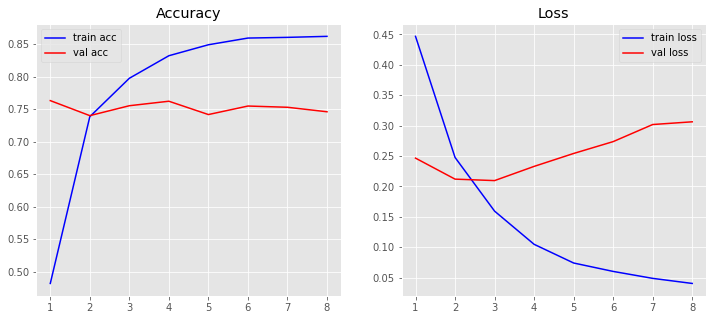

In [ ]:
plot_history(history)

In [ ]:
y_pred = model.predict(X_test_tk).round()

In [ ]:
print(classification_report(y_test, y_pred, target_names=labels, digits=3))
print('hamming loss : {} \n'.format(hamming_loss(y_test, y_pred)))

                      precision    recall  f1-score   support

    Computer Science      0.802     0.846     0.823      1692
             Physics      0.889     0.860     0.874      1226
         Mathematics      0.833     0.777     0.804      1150
          Statistics      0.780     0.669     0.720      1069
Quantitative Biology      0.000     0.000     0.000       122
Quantitative Finance      0.000     0.000     0.000        45

           micro avg      0.826     0.772     0.798      5304
           macro avg      0.551     0.525     0.537      5304
        weighted avg      0.799     0.772     0.784      5304
         samples avg      0.839     0.810     0.805      5304

hamming loss : 0.08247914183551848 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This model did not work well as there is no prediction at all for the minority classes.

# Word Vectors from LexVec

Next, I embed word vectors extracted from LexVec and train models with different layers.

## Import LexVec

In [13]:
lexvec_path = '/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/pre-trained word embeddings/lexvec.enwiki+newscrawl.300d.W.pos.vectors'

wordembeddings = KeyedVectors.load_word2vec_format(lexvec_path)

In [14]:
vocab_size = len(word_index) + 1
skipped_words = 0
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [15]:
for word, index in word_index.items():
  try:
    embedding_vector = wordembeddings[word]
  except:
    skipped_words +=1
    pass
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [16]:
# to be fed into first embedding layer
embedding_matrix.shape

(51713, 300)

In [17]:
skipped_words

18554

In [18]:
word_index['neural']

87

In [19]:
# check that the word vector for 'neural' from LexVec correspond in the embedding matrix.
embedding_matrix[87]-wordembeddings['neural']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## Model - Simple RNN

In [20]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_len,
                    weights=[embedding_matrix],
                    trainable=False))
model.add(SimpleRNN(64, activation='relu', return_sequences=False))
model.add(Dropout(0.2))  
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='sigmoid'))  
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 467, 300)          15513900  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                23360     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 102       
Total params: 15,538,402
Trainable params: 15,538,402
Non-trainable params: 0
____________________________________________

In [ ]:
ckpt_path = '/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/models/simple RNN with LexVec'

modelckpt = ModelCheckpoint(filepath=ckpt_path,
                            monitor='val_loss',
                            save_best_only=True,
                            save_weights_only=False,
                            verbosity=1,
                            save_freq='epoch',
                            mode='min')

In [ ]:
history = model.fit(X_train_tk, y_train,
                    epochs=100,  
                    verbose=True,
                    validation_data=(X_test_tk, y_test),
                    batch_size=128,
                    callbacks=modelckpt
                    )  

Epoch 1/100
132/132 [==============================] - 57s 423ms/step - loss: 0.5442 - accuracy: 0.2949 - val_loss: 0.3141 - val_accuracy: 0.7163
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/models/simple RNN with LexVec/assets
Epoch 2/100
132/132 [==============================] - 56s 427ms/step - loss: 0.3510 - accuracy: 0.6374 - val_loss: 0.3987 - val_accuracy: 0.5821
Epoch 3/100
132/132 [==============================] - 56s 423ms/step - loss: 0.3472 - accuracy: 0.6743 - val_loss: 0.3146 - val_accuracy: 0.7006
Epoch 4/100
132/132 [==============================] - 56s 422ms/step - loss: 0.3141 - accuracy: 0.7072 - val_loss: 0.3063 - val_accuracy: 0.7316
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/models/simple RNN with LexVec/assets
Epoch 5/100
132/132 [==============================] - 56s 421ms/step - loss: 0.3071 - accuracy: 0.7252 - va

KeyboardInterrupt: ignored

In [ ]:
# load saved model to skip training
ckpt_path = '/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/models/simple RNN with LexVec'
model = load_model(ckpt_path)

In [ ]:
loss, accuracy = model.evaluate(X_train_tk, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_tk, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))

525/525 [==============================] - 22s 42ms/step - loss: 0.2683 - accuracy: 0.7536
Training Accuracy: 0.7536
132/132 [==============================] - 6s 42ms/step - loss: 0.2803 - accuracy: 0.7440
Testing Accuracy:  0.7440


In [ ]:
y_pred = model.predict(X_test_tk)

In [ ]:
y_pred = y_pred.round()

In [ ]:
print(classification_report(y_test, y_pred, target_names=labels, digits=3))
print('hamming loss : {} \n'.format(hamming_loss(y_test, y_pred)))

                      precision    recall  f1-score   support

    Computer Science      0.702     0.858     0.772      1692
             Physics      0.896     0.763     0.824      1226
         Mathematics      0.816     0.683     0.744      1150
          Statistics      0.000     0.000     0.000      1069
Quantitative Biology      0.000     0.000     0.000       122
Quantitative Finance      0.000     0.000     0.000        45

           micro avg      0.779     0.598     0.677      5304
           macro avg      0.402     0.384     0.390      5304
        weighted avg      0.608     0.598     0.598      5304
         samples avg      0.757     0.656     0.689      5304

hamming loss : 0.12050059594755662 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can observe that simple RNN performed worse than a simple neural network.

## Model - LSTM + GRU with LexVec

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_len,
                    weights=[embedding_matrix],
                    trainable=False))
model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.15))
model.add(GRU(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.15))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='sigmoid'))  
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 467, 300)          15513900  
_________________________________________________________________
lstm (LSTM)                  (None, 467, 64)           93440     
_________________________________________________________________
gru (GRU)                    (None, 64)                24960     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 102       
Total params: 15,633,442
Trainable params: 119,542
Non-trainable params: 15,513,900
____________________________________

In [ ]:
ckpt_path = '/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/models/LTSM + GRU with LexVec'

modelckpt = ModelCheckpoint(filepath=ckpt_path,
                            monitor='val_loss',
                            save_best_only=True,
                            save_weights_only=False,
                            verbosity=1,
                            save_freq='epoch',
                            mode='min')

In [ ]:
history = model.fit(X_train_tk, y_train,
                    epochs=100,  
                    verbose=True,
                    validation_data=(X_test_tk, y_test),
                    batch_size=128,
                    callbacks=modelckpt
                    )  

Epoch 1/100
132/132 [==============================] - 580s 4s/step - loss: 0.1884 - accuracy: 0.7608 - val_loss: 0.1856 - val_accuracy: 0.7311
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/models/LTSM + GRU with LexVec/assets
Epoch 2/100
132/132 [==============================] - 569s 4s/step - loss: 0.1570 - accuracy: 0.7846 - val_loss: 0.1906 - val_accuracy: 0.7790
Epoch 3/100
132/132 [==============================] - 562s 4s/step - loss: 0.1295 - accuracy: 0.8045 - val_loss: 0.2009 - val_accuracy: 0.7280
Epoch 4/100
 29/132 [=====>........................] - ETA: 7:15 - loss: 0.1047 - accuracy: 0.8260

In [ ]:
# load saved model to skip training
ckpt_path = '/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/models/LTSM + GRU with LexVec'
model = load_model(ckpt_path)

In [ ]:
loss, accuracy = model.evaluate(X_train_tk, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_tk, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))

525/525 [==============================] - 97s 183ms/step - loss: 0.1458 - accuracy: 0.7735
Training Accuracy: 0.7735
132/132 [==============================] - 24s 180ms/step - loss: 0.1856 - accuracy: 0.7311
Testing Accuracy:  0.7311


In [ ]:
y_pred = model.predict(X_test_tk)

In [ ]:
y_pred = y_pred.round()

In [ ]:
print(classification_report(y_test, y_pred, target_names=labels, digits=3))
print('hamming loss : {} \n'.format(hamming_loss(y_test, y_pred)))

                      precision    recall  f1-score   support

    Computer Science      0.855     0.772     0.811      1692
             Physics      0.912     0.848     0.879      1226
         Mathematics      0.841     0.775     0.806      1150
          Statistics      0.779     0.790     0.785      1069
Quantitative Biology      0.471     0.066     0.115       122
Quantitative Finance      0.500     0.022     0.043        45

           micro avg      0.847     0.771     0.807      5304
           macro avg      0.726     0.546     0.573      5304
        weighted avg      0.838     0.771     0.798      5304
         samples avg      0.829     0.809     0.801      5304

hamming loss : 0.07759237187127532 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
